In [6]:
#Setup
import numpy as np
from numpy.testing import assert_almost_equal
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib.pyplot as plt 


## Part 0 - Setup

In [7]:
### Constants
sigma1 = 0.11
sigma2 = 0.13
T = 1.7
sim_end_time = T #This is true in Q1, not later on
mu = 0.13
r = 0.01
S0 = 149
time_break = 0.3
K = 188
KH = S0
n_sims = 5_000 #default value, overwritten later
n_steps = int(T * 365) #Assume time in years, this is daily time-steps

In [8]:
### Helper Functions

### Time-varying vol

def time_varying_vol(t):
    if t > time_break:
        return sigma1 + sigma2 * (t - time_break)/(T - time_break)
    return sigma1

assert_almost_equal(np.array([time_varying_vol(0.2), time_varying_vol(0.4), time_varying_vol(0.5), time_varying_vol(T)]) ,
                    np.array([sigma1, 0.11928571428, 0.128571429, sigma1 + sigma2]))

def integrate_vol(start_time = 0, end_time = T):
    squared_vol = lambda x: time_varying_vol(x) ** 2
    result = integrate.quad(squared_vol, start_time, end_time)
    return result[0]

assert_almost_equal(np.array([integrate_vol(end_time = time_break), integrate_vol(0, 1), integrate_vol(start_time = 0)]),
                    np.array([time_break * sigma1 ** 2, 0.018090833333, 0.0484766666]))

### Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2

def black_scholes_call_price(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return S * norm.cdf(d1) - K * np.exp(-r * (T- t)) * norm.cdf(d2)

def black_scholes_put_price(S,t, K,T,r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return  K * np.exp(-r * (T - t)) * norm.cdf( -d2) - S * norm.cdf(-d1) 

def black_scholes_call_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.cdf(d1)

def black_scholes_put_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return -1 * norm.cdf(-1 * d1)

def black_scholes_gamma(S, t, K, T, r,sigma):
    #same for a call and put
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.pdf(d1)/(S * sigma * np.sqrt(T - t))


assert_almost_equal(black_scholes_call_price(100,0,  100, 1, 0.01, 0.2), 8.43332, decimal = 5)
assert_almost_equal(black_scholes_call_price(100,0.99,  95, 1, 0.01, 0.2), 5.01264, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0, 100, 1, 0.01, 0.2), 7.43831, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0.99,  95, 1, 0.01, 0.2), 0.00314, decimal = 5)

assert_almost_equal(black_scholes_call_delta(100,0, 100, 1, 0.01, 0.2), 0.55962, decimal = 5)
assert_almost_equal(black_scholes_call_delta(100,0.99,  95, 1, 0.01, 0.2), 0.99506, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0, 100, 1, 0.01, 0.2), -0.44038, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0.99, 95, 1, 0.01, 0.2), -0.00494, decimal = 5)


assert_almost_equal(black_scholes_gamma(100,0, 100, 1, 0.01, 0.2), 0.01972, decimal = 5)
assert_almost_equal(black_scholes_gamma(100,0.99, 95, 1, 0.01, 0.2), 0.00716, decimal = 5)




## Q1 - Delta Hedging

In [9]:
class Hedger:
    def __init__(self, S0, K, T, r, mu, n_sims, n_steps,simulation_end_time = None, constant_vol_assumption = False, do_gamma_hedging = False):
        
        #Inputs
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.mu = mu
        self.constant_vol_assumption = constant_vol_assumption
        self.n_sims = n_sims
        self.n_steps = n_steps

        if simulation_end_time is not None:
            self.simulation_end_time = simulation_end_time
        else:
            if constant_vol_assumption:
                self.simulation_end_time = T / 2 #All questions with constant vol only simulate to time T/2
            else:
                self.simulation_end_time = T

        self.do_gamma_hedging = do_gamma_hedging

        #Derived
        self.simulation_setup()

        #Always need paths and payoffs, so do this now
        self.simulate_gbm()
        self.get_call_prices()
    
    def simulation_setup(self):
        self.dt = self.simulation_end_time / self.n_steps
        self.rng = np.random.default_rng(seed = 42) #For reproducibility
        
        if self.constant_vol_assumption:
            self.full_period_vol = time_varying_vol(self.T)
        else:
            self.full_period_vol = np.sqrt(1 / self.T * integrate_vol(end_time = self.T))
    
        self.initial_price = black_scholes_call_price(self.S0, 0, self.K, self.T, self.r, self.full_period_vol)

    def simulate_gbm(self):
        
        self.times = np.linspace(0, self.simulation_end_time, self.n_steps + 1)
        epsilon = self.rng.normal(size = [self.n_sims, self.n_steps])
        
        paths = np.zeros([self.n_sims, self.n_steps + 1])
        paths[:, 0] = self.S0

        for i in range(0, self.n_steps):
            #Euler-Maruyama Scheme
            paths[:, i + 1] = paths[:, i] + paths[:, i] * self.mu * self.dt + paths[:, i] * time_varying_vol(self.times[i]) * np.sqrt(self.dt) * epsilon[:, i]
        
        self.paths = paths

    def get_call_prices(self):
        
        S_T = self.paths[:, -1]
        if self.simulation_end_time == self.T:
            self.call_prices = np.maximum(S_T - self.K, 0)
        elif self.constant_vol_assumption:
            self.call_prices = black_scholes_call_price(S_T, self.simulation_end_time, self.K, self.T, self.r, time_varying_vol(self.T))
        else:
            int_vol = np.sqrt(1 / (self.T - self.simulation_end_time) * integrate_vol(start_time = self.simulation_end_time, end_time = self.T))
            self.call_prices = black_scholes_call_price(S_T, self.simulation_end_time, self.K, self.T, self.r, int_vol)                  

    def simulate_delta_varying_vol(self):

        portfolio = np.zeros(self.paths.shape)
        portfolio[:, 0] = self.initial_price

        for i in range(0, len(self.times) - 1):
            t = self.times[i]
        
            S_at_t = self.paths[:, i] 
            S_at_t_plus_dt = self.paths[:, i+1]

            if self.constant_vol_assumption:
                vol_t = time_varying_vol(self.T)
            else:
                vol_t = np.sqrt(1 / (T - t) * integrate_vol(start_time = t, end_time = T))

            delta_t = black_scholes_call_delta(S_at_t, t, K, T, r, vol_t)

            bank_at_t = portfolio[:, i] - delta_t * S_at_t 
            
            bank_at_t_plus_dt = bank_at_t * np.exp(self.dt * self.r)
            new_stock_value = delta_t * S_at_t_plus_dt

            portfolio[:, i + 1] = bank_at_t_plus_dt + new_stock_value

        self.portfolio = portfolio
        
        final_portfolio = portfolio[:, -1]
        error = final_portfolio - self.call_prices
        return error, self.initial_price
                                                
        


(array([   3.,    2.,    5.,    8.,   18.,   36.,   92.,  197.,  421.,
         898., 1729.,  857.,  373.,  191.,   81.,   49.,   22.,    9.,
           4.,    5.]),
 array([-0.40357168, -0.36501452, -0.32645735, -0.28790018, -0.24934301,
        -0.21078584, -0.17222867, -0.1336715 , -0.09511433, -0.05655717,
        -0.018     ,  0.02055717,  0.05911434,  0.09767151,  0.13622868,
         0.17478585,  0.21334301,  0.25190018,  0.29045735,  0.32901452,
         0.36757169]),
 <BarContainer object of 20 artists>)

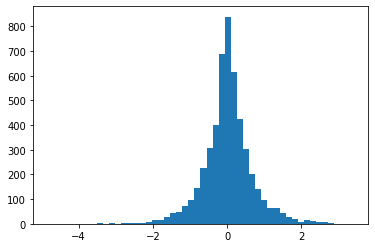

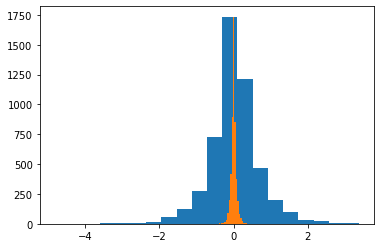

In [10]:
Q1 = Hedger(S0, K, T, r, mu, n_sims, n_steps)
error_Q1, price_Q1 = Q1.simulate_delta_varying_vol()
plt.figure(0)
plt.hist(error_Q1, bins = 50)

High_steps_Q1 = Hedger(S0, K, T, r, mu, n_sims, n_steps * 100)
error2, price2 = High_steps_Q1.simulate_delta_varying_vol()

plt.figure(1)
plt.hist(error_Q1, bins = 20)
plt.hist(error2, bins = 20)

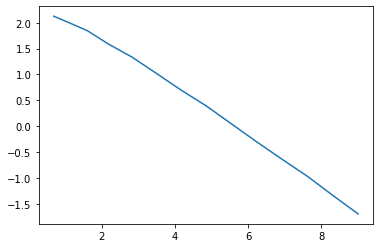

In [11]:
n_points = 14
n_steps_rme_testing = np.zeros(n_points)
rms_error = np.zeros(n_points)
for i in range(0, n_points):
    n_steps_rme_testing[i] = 2 ** i + 1
    dummy_hedger = Hedger(S0, K, T, r, mu, n_sims, int(n_steps_rme_testing[i]))
    error, price = dummy_hedger.simulate_delta_varying_vol()
    rms_error[i] = np.sqrt(np.mean(error ** 2))

ax = plt.gca()
ax.plot(np.log(n_steps_rme_testing), np.log(rms_error))

## Q2

In [20]:
Dummy = Hedger(S0, K, T, r, mu, n_sims, n_steps, simulation_end_time = T/2)

e, p = Dummy.simulate_delta_varying_vol()

(array([  1.,   3.,  10.,  15.,  41.,  72., 153., 279., 439., 648., 870.,
        835., 691., 436., 272., 135.,  65.,  20.,  10.,   5.]),
 array([-0.46057624, -0.41827499, -0.37597375, -0.33367251, -0.29137126,
        -0.24907002, -0.20676878, -0.16446753, -0.12216629, -0.07986505,
        -0.0375638 ,  0.00473744,  0.04703868,  0.08933993,  0.13164117,
         0.17394241,  0.21624366,  0.2585449 ,  0.30084614,  0.34314739,
         0.38544863]),
 <BarContainer object of 20 artists>)

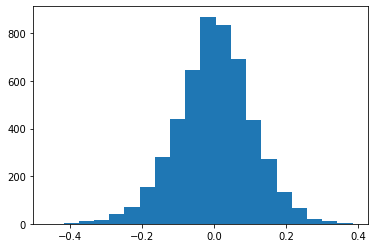

In [21]:
plt.hist(e, bins = 20)

In [14]:
Q2_Test = Hedger(S0, K, 0.3, r, mu, 100_000, 1_000, simulation_end_time = 0.15, constant_vol_assumption = True)
Q2_test_error, Q2_price_error = Q2_Test.simulate_delta_varying_vol()


(array([1.8769e+04, 3.2080e+04, 2.1606e+04, 1.2542e+04, 6.7870e+03,
        3.6530e+03, 1.9320e+03, 1.1870e+03, 6.1000e+02, 3.5800e+02,
        1.9300e+02, 1.2100e+02, 6.8000e+01, 4.9000e+01, 2.1000e+01,
        1.1000e+01, 8.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-0.68366467, -0.30405965,  0.07554537,  0.45515039,  0.83475541,
         1.21436043,  1.59396545,  1.97357047,  2.35317549,  2.73278051,
         3.11238553,  3.49199055,  3.87159557,  4.25120059,  4.63080561,
         5.01041063,  5.39001566,  5.76962068,  6.1492257 ,  6.52883072,
         6.90843574]),
 <BarContainer object of 20 artists>)

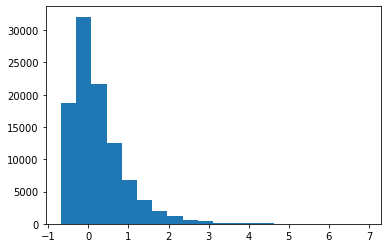

In [15]:
plt.hist(Q2_test_error, bins = 20)

In [16]:
Q2 = Hedger(S0, K, T, r, mu, 1_000, 1_000, simulation_end_time = T/2, constant_vol_assumption = True)
error_Q2, price_Q2 = Q2.simulate_delta_varying_vol()


(array([ 1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  3.,  5.,  6.,
         6., 12.,  7., 10., 16., 14., 27., 14., 20., 26., 28., 21., 19.,
        33., 31., 39., 42., 33., 51., 48., 40., 46., 54., 42., 53., 44.,
        33., 37., 39., 38., 27., 17.,  7.,  6.,  0.,  0.,  1.]),
 array([1.46217267, 1.52796355, 1.59375444, 1.65954532, 1.7253362 ,
        1.79112709, 1.85691797, 1.92270886, 1.98849974, 2.05429062,
        2.12008151, 2.18587239, 2.25166328, 2.31745416, 2.38324504,
        2.44903593, 2.51482681, 2.5806177 , 2.64640858, 2.71219947,
        2.77799035, 2.84378123, 2.90957212, 2.975363  , 3.04115389,
        3.10694477, 3.17273565, 3.23852654, 3.30431742, 3.37010831,
        3.43589919, 3.50169007, 3.56748096, 3.63327184, 3.69906273,
        3.76485361, 3.83064449, 3.89643538, 3.96222626, 4.02801715,
        4.09380803, 4.15959891, 4.2253898 , 4.29118068, 4.35697157,
        4.42276245, 4.48855333, 4.55434422, 4.6201351 , 4.68592599,
        4.75171687]),
 <BarContainer

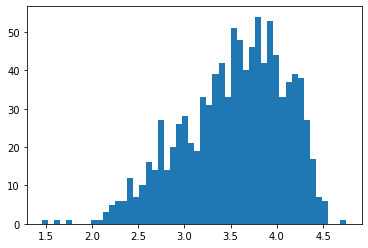

In [17]:
plt.hist(error_Q2, bins = 50)

In [18]:
np.percentile(error_Q2, q = [2.5, 97.5])

array([2.38401743, 4.37940813])

In [19]:
np.mean(error_Q2)

3.544389515283507